In [408]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, KMeans
import missingno as msno
import geopandas as gpd
from shapely import wkt
import numpy as np
from shapely.geometry import MultiPoint, Point
from scipy.spatial import QhullError
from scipy.stats import pearsonr
import statsmodels.api as sm
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import os, re



/tmp/ipykernel_5750/2446858160.py:1: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  cartofriches = pd.read_csv("data/cartofriches.csv", sep=";")


<Axes: >

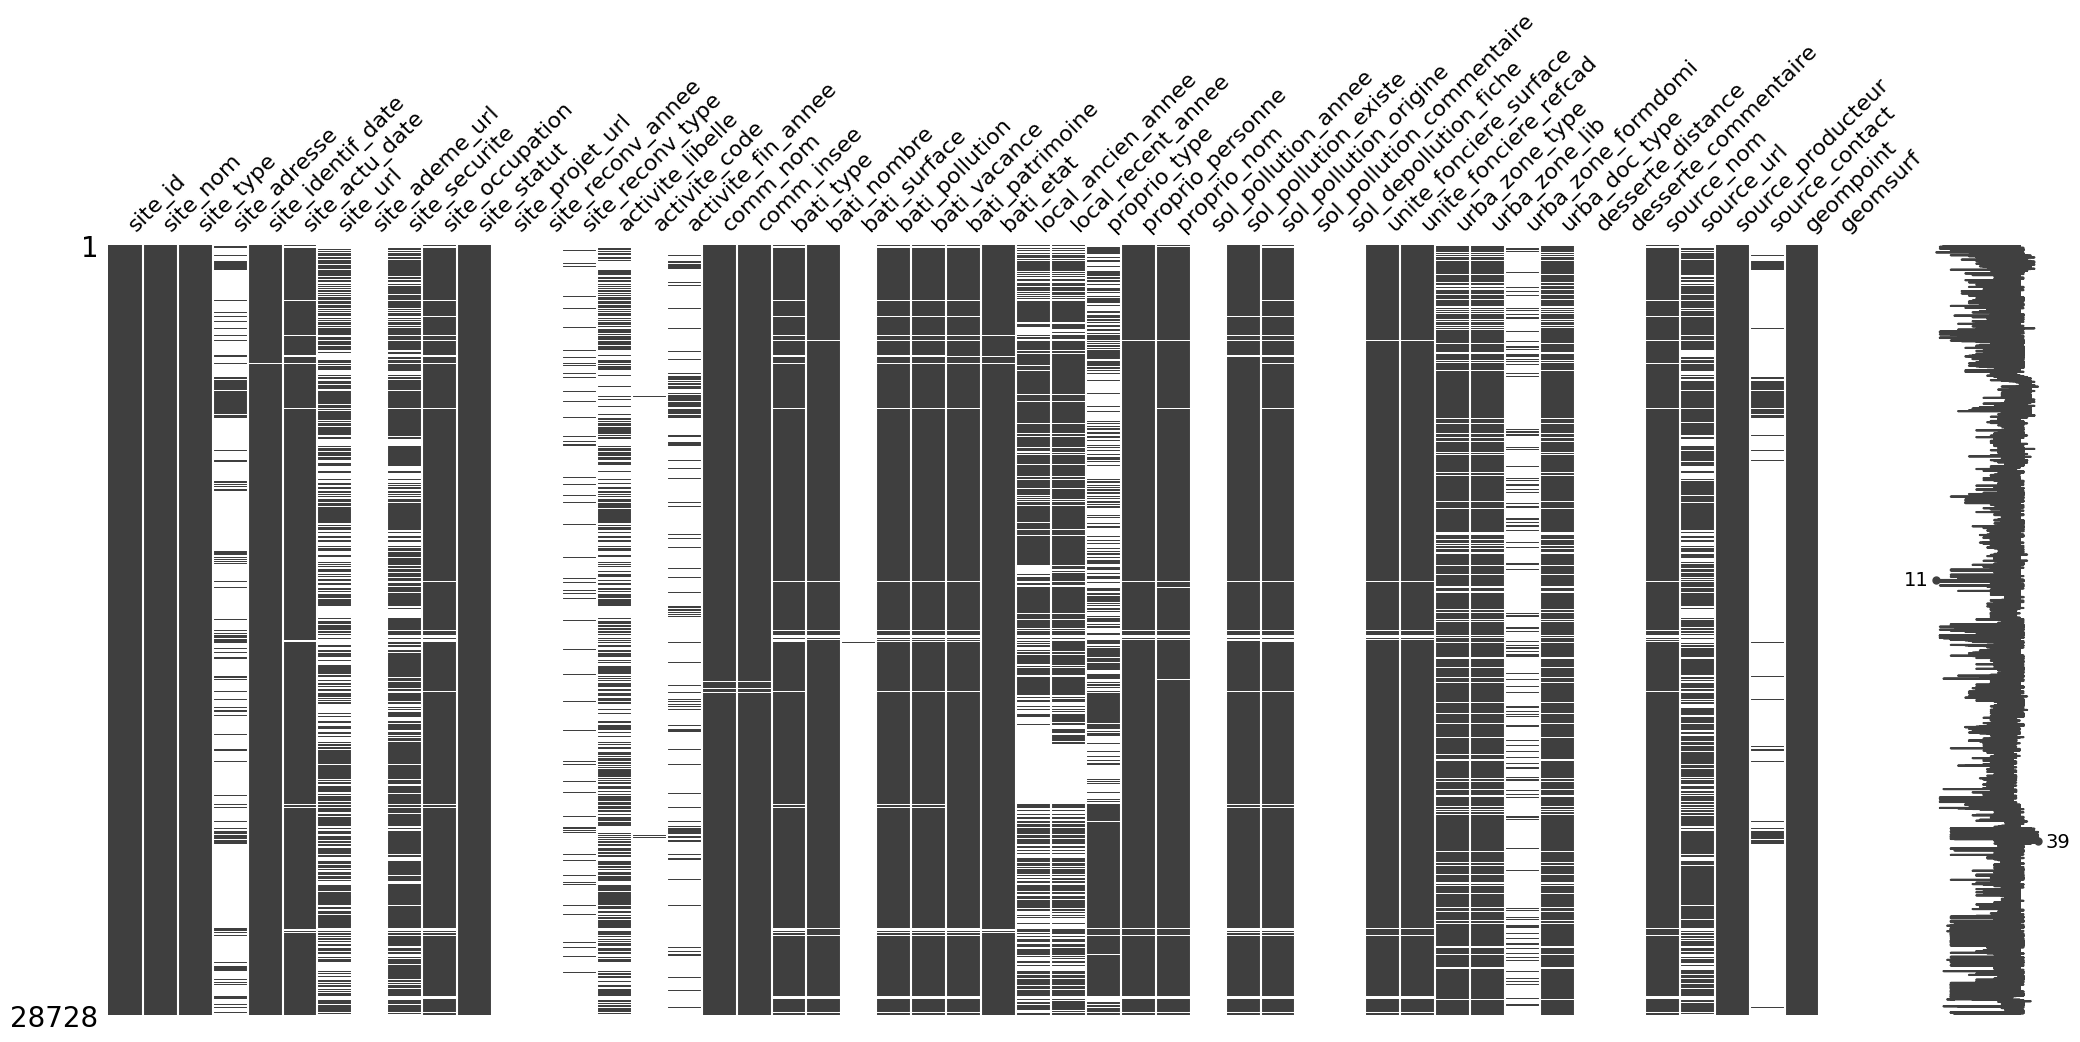

In [409]:
cartofriches = pd.read_csv("data/cartofriches.csv", sep=";")
msno.matrix(cartofriches)

In [410]:
regions = gpd.read_file("data/regions.geojson")
idf = regions[regions["nom"] == "Île-de-France"]
hdf = regions[regions["nom"] == "Hauts-de-France"]
cartofriches["geompoint"] = cartofriches["geompoint"].apply(wkt.loads)
ihdf = pd.concat([idf, hdf])

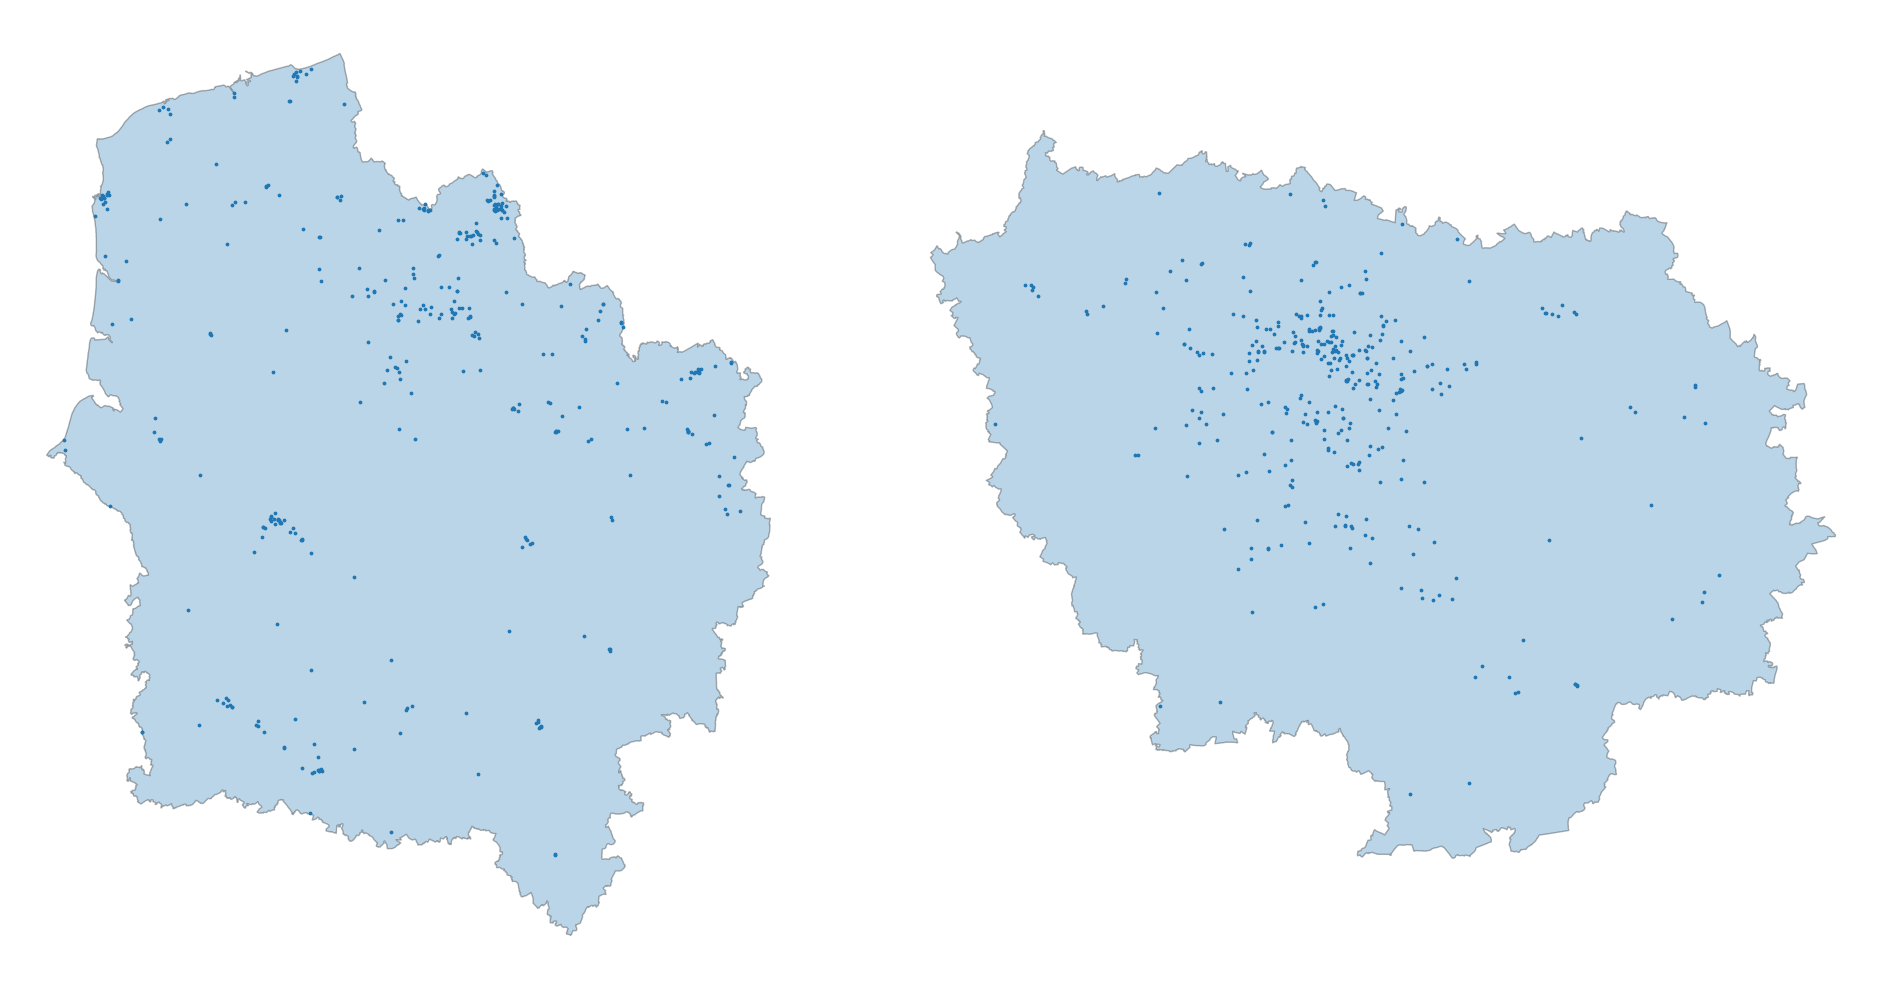

In [411]:
friches = gpd.GeoDataFrame(
    cartofriches[cartofriches["site_statut"].str.contains(r"reconvertie|avec")],
    geometry="geompoint",
    crs="EPSG:4326"
)

friches_hdf = friches[friches.within(hdf.union_all())]
friches_idf = friches[friches.within(idf.union_all())]
friches_ihdf = friches[friches.within(ihdf.union_all())]

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

ax = axes[0]
hdf.plot(ax=ax, alpha=.3, edgecolor="black")
friches_hdf.plot(ax=ax, markersize=3)
ax.axis("off")

ax = axes[1]
idf.plot(ax=ax, alpha=.3, edgecolor="black")
friches_idf.plot(ax=ax, markersize=3)
ax.axis("off")

plt.tight_layout()
plt.show()


/tmp/ipykernel_5750/37060094.py:4: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  friches_clusters = friches[(friches["cluster"] != -1) & (friches.within(ihdf.unary_union))]


<Axes: >

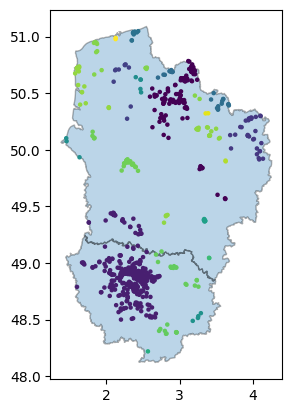

In [412]:
coords = np.vstack((friches.geometry.x, friches.geometry.y)).T
db = DBSCAN(eps=0.12, min_samples=2).fit(coords)
friches["cluster"] = db.labels_
friches_clusters = friches[(friches["cluster"] != -1) & (friches.within(ihdf.unary_union))]
ax = ihdf.plot(alpha=.3, edgecolor="black")
friches_clusters.plot(ax=ax, column="cluster", markersize=5)

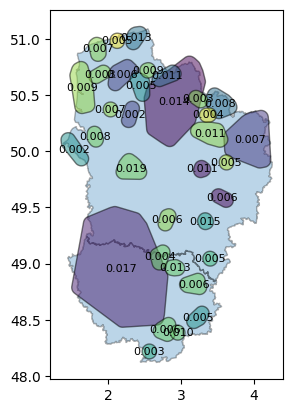

In [413]:
friches_m = friches_clusters.to_crs(3857)

polygons_m = (
    friches_m
    .dissolve(by="cluster")
    .convex_hull
    .reset_index()
)

polygons_m = polygons_m.rename(columns={0: "geometry"})
polygons_m = gpd.GeoDataFrame(polygons_m, geometry="geometry", crs=3857)

buffer_distance = 11000
polygons_m["geometry"] = polygons_m.geometry.buffer(buffer_distance)

polygons_gdf = polygons_m.to_crs(4326)


gdf_points_m = friches_clusters.to_crs(3857)

join = gpd.sjoin(
    gdf_points_m,
    polygons_m,
    how="left",
    predicate="within"
)

counts = (
    join.groupby("index_right")
        .size()
        .reset_index(name="count")
)

polygons_m["area_m2"] = polygons_m.area
polygons_m = polygons_m.reset_index()

polygons_m = polygons_m.merge(
    counts,
    left_on="index",
    right_on="index_right",
    how="left"
)

polygons_m["density_m2"] = polygons_m["count"] / polygons_m["area_m2"]
polygons_m["density_km2"] = polygons_m["density_m2"] * 1e6


centroids_m = polygons_m.copy()
centroids_m["geometry"] = centroids_m.centroid

centroids = centroids_m.to_crs(4326)[["density_km2", "geometry"]]


polygons = polygons_m.to_crs(4326)


ax = ihdf.plot(alpha=.3, edgecolor="black")
polygons.plot(ax=ax, column="cluster", alpha=0.5, edgecolor="black")

for x, y, label in zip(centroids.geometry.x, centroids.geometry.y, centroids["density_km2"]):
    ax.text(x, y, f"{label:.3f}", fontsize=8, ha="center", va="center")

In [414]:
csp_2021 = pd.read_csv("data/CSP2021.csv", low_memory=False)
csp_1968 = pd.read_csv("data/CSP1968.csv", low_memory=False)

<Axes: >

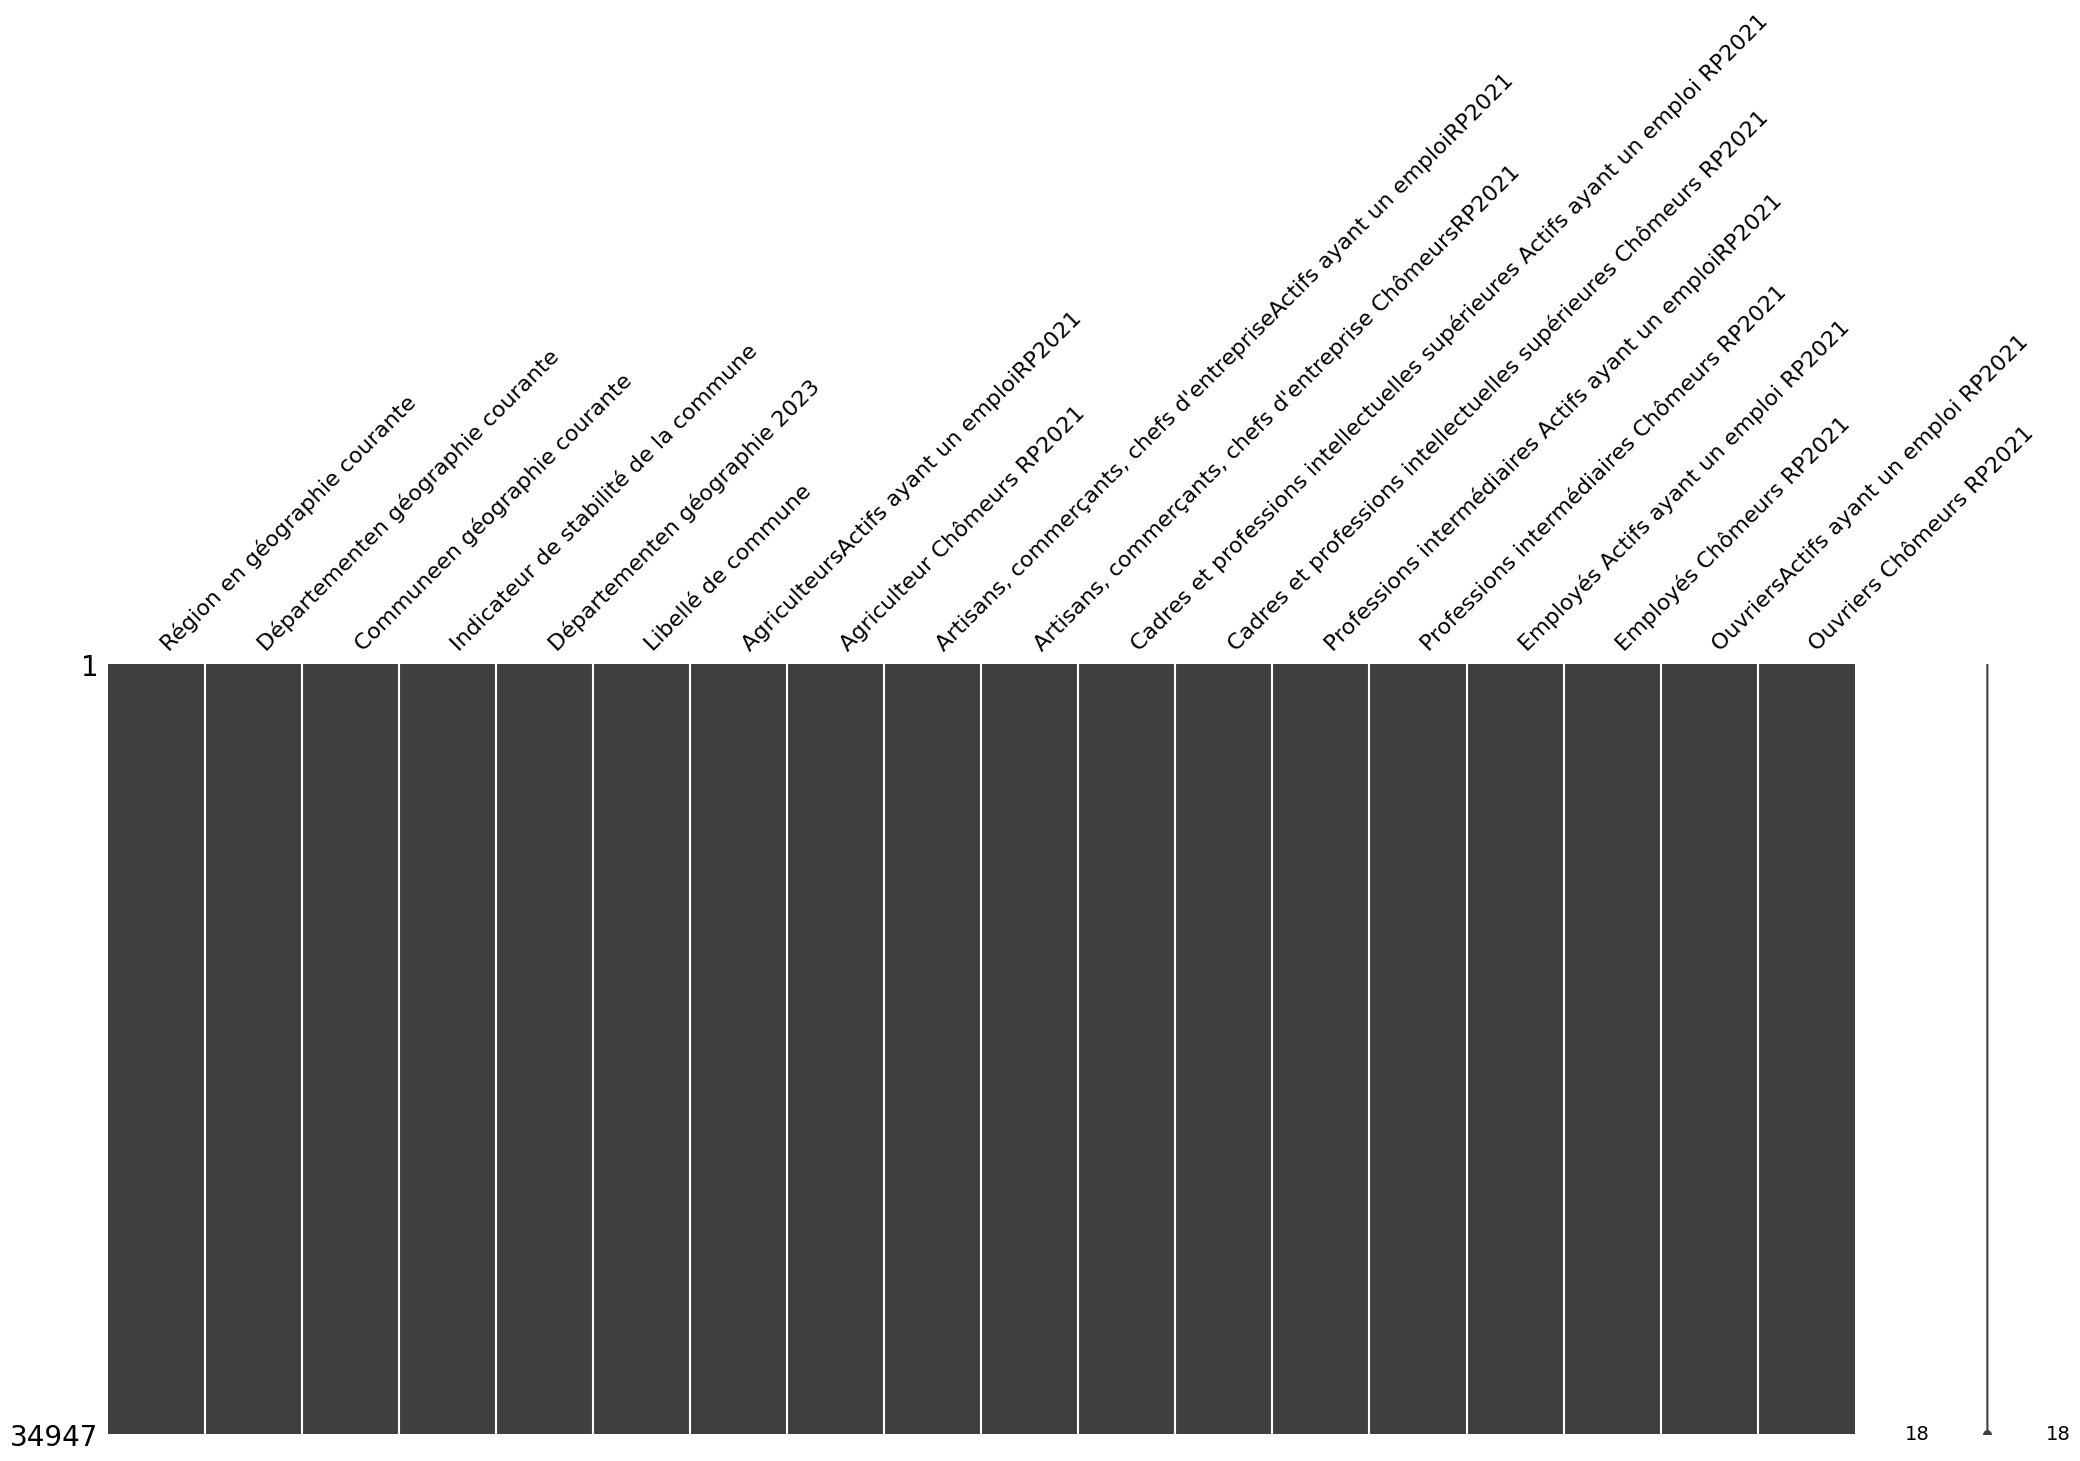

In [415]:
csp_2021.dropna(axis=0, inplace=True)
csp_1968.dropna(axis=0, inplace=True)
msno.matrix(csp_2021)

In [416]:
csp_2021.iloc[:, 6:] = csp_2021.iloc[:, 6:].apply(lambda x: pd.to_numeric(x.str.replace('\u202f','', regex=False) if x.dtype == 'object' else x, errors='coerce'))
csp_2021 = csp_2021[csp_2021["Région en géographie courante"].isin([11, 32])]
csp_2021["Total"] = csp_2021.iloc[:, 6:len(csp_2021.columns)].sum(axis=1)
csp_2021 = csp_2021[csp_2021["Total"] > 0]
csp_2021["Cadres et professions intellectuelles supérieures Actifs ayant un emploi RP2021%"] = csp_2021["Cadres et professions intellectuelles supérieures Actifs ayant un emploi RP2021"] / csp_2021["Total"] * 100
csp_2021 = csp_2021[["Libellé de commune", "Cadres et professions intellectuelles supérieures Actifs ayant un emploi RP2021%", "Cadres et professions intellectuelles supérieures Actifs ayant un emploi RP2021", "Total"]]

csp_1968.iloc[:, 6:] = csp_1968.iloc[:, 6:].apply(lambda x: pd.to_numeric(x.str.replace('\u202f','', regex=False) if x.dtype == 'object' else x, errors='coerce'))
csp_1968 = csp_1968[csp_1968["Région en géographie courante"].isin([11, 32])]
csp_1968["Total"] = csp_1968.iloc[:, 6:len(csp_1968.columns)].sum(axis=1)
csp_1968 = csp_2021[csp_1968["Total"] > 0]
csp_1968["Cadres et professions intellectuelles supérieures Actifs ayant un emploi RP2021%"] = csp_1968["Cadres et professions intellectuelles supérieures Actifs ayant un emploi RP2021"] / csp_1968["Total"] * 100
csp_1968 = csp_1968[["Libellé de commune", "Cadres et professions intellectuelles supérieures Actifs ayant un emploi RP2021%", "Cadres et professions intellectuelles supérieures Actifs ayant un emploi RP2021", "Total"]]

/tmp/ipykernel_5750/3148476668.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  csp_1968 = csp_2021[csp_1968["Total"] > 0]
/tmp/ipykernel_5750/3148476668.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  csp_1968["Cadres et professions intellectuelles supérieures Actifs ayant un emploi RP2021%"] = csp_1968["Cadres et professions intellectuelles supérieures Actifs ayant un emploi RP2021"] / csp_1968["Total"] * 100


In [417]:
communes = gpd.read_file("data/communes.geojson")
communes = communes.iloc[:,1:]
communes = communes.to_crs(epsg=4326)
communes = communes[communes.geometry.within(ihdf.unary_union)]
communes = communes.reset_index()  

communes_2021 = communes.merge(csp_2021, left_on="nom", right_on="Libellé de commune", how="inner")
communes_1968 = communes.merge(csp_1968, left_on="nom", right_on="Libellé de commune", how="inner")

if "level_0" in communes.columns:
    communes = communes.drop(columns=["level_0"])

communes = communes.reset_index(drop=True)

if 0 in polygons.columns:
    polygons = polygons.rename(columns={0: "geometry"})

for col in ["index_right"]:
    if col in polygons.columns:
        polygons = polygons.drop(columns=[col])

polygons = polygons.reset_index(drop=True)

polygons = polygons.set_geometry("geometry")


join = gpd.sjoin(
    communes,
    polygons[["geometry", "density_km2"]],
    how="left",
    predicate="intersects"
)


regions_density = (
    join.groupby("index")["density_km2"]
        .sum()
        .reset_index()
)

communes = communes.merge(
    regions_density,
    on="index",
    how="left"
)

communes["density_km2"] = communes["density_km2"].fillna(0)

/tmp/ipykernel_5750/694624496.py:4: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  communes = communes[communes.geometry.within(ihdf.unary_union)]


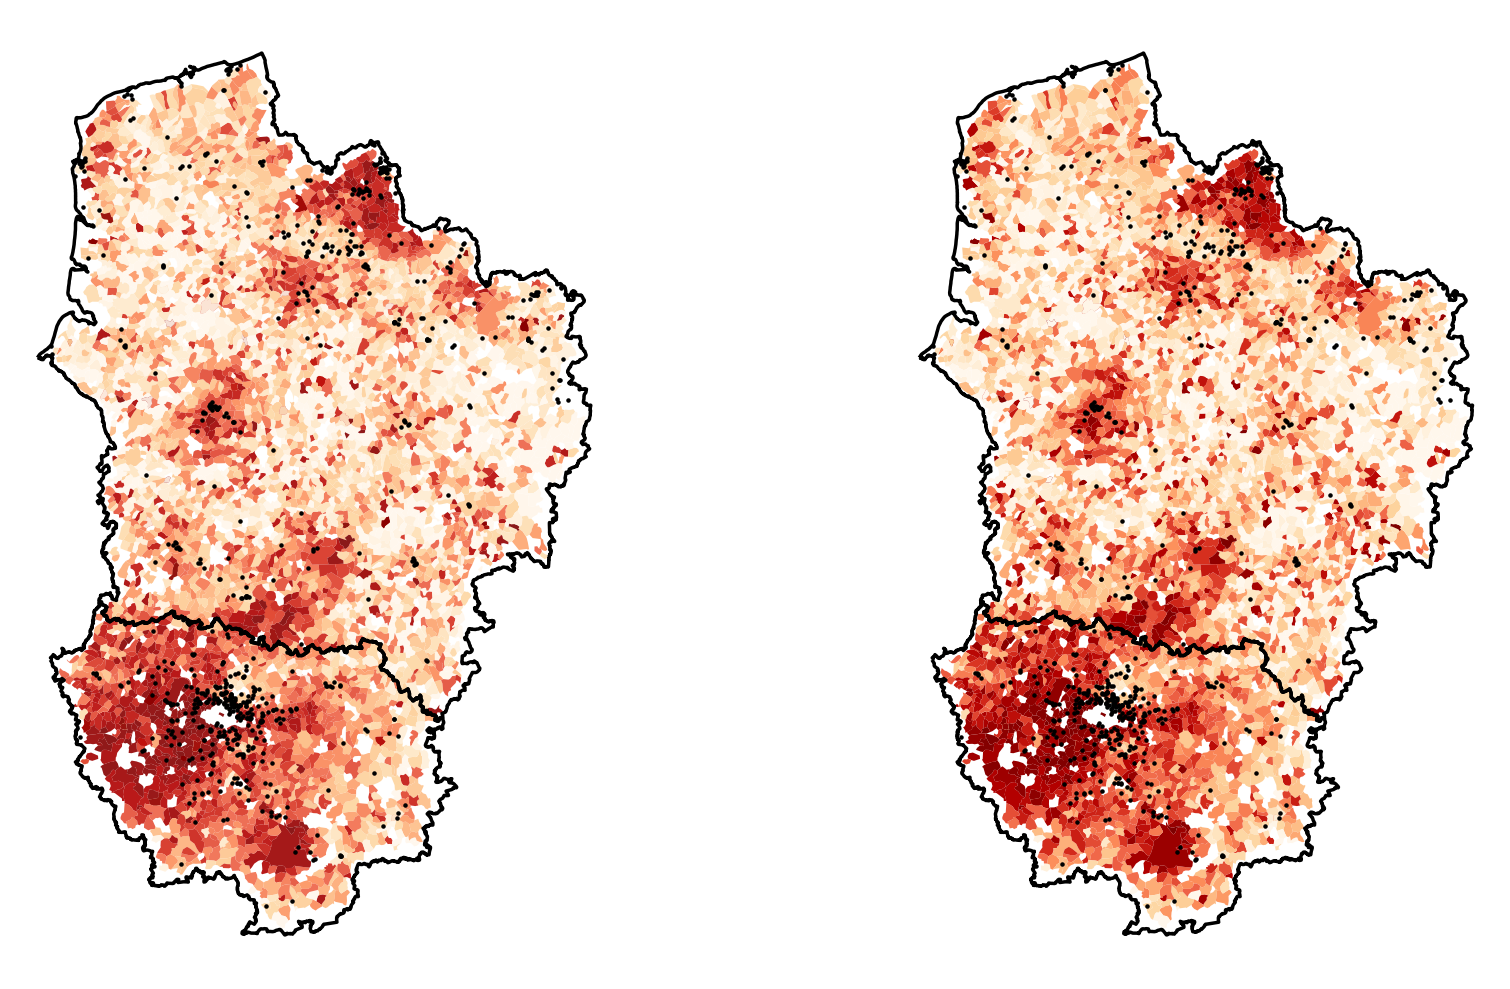

In [418]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

ax = axes[0]
communes_2021.plot(
    ax=ax,
    alpha=.9,
    linewidth=0,
    column="Cadres et professions intellectuelles supérieures Actifs ayant un emploi RP2021%",
    cmap="OrRd"
)
ihdf.boundary.plot(ax=ax, color="black", linewidth=2.5)
friches_ihdf.plot(ax=ax, markersize=5, color="black")
ax.axis('off')

ax = axes[1]
communes_1968.plot(
    ax=ax,
    alpha=1,
    linewidth=0,
    column="Cadres et professions intellectuelles supérieures Actifs ayant un emploi RP2021%",
    cmap="OrRd"
)
ihdf.boundary.plot(ax=ax, color="black", linewidth=2.5)
friches_ihdf.plot(ax=ax, markersize=5, color="black")
ax.axis('off')

plt.tight_layout()
plt.show()

In [419]:
diff = pd.DataFrame()
diff["Libellé de commune"] = communes_2021["Libellé de commune"]
diff["%Cadres"] = communes_2021["Cadres et professions intellectuelles supérieures Actifs ayant un emploi RP2021%"] - communes_1968["Cadres et professions intellectuelles supérieures Actifs ayant un emploi RP2021%"]
diff["Pop"] = communes_2021["Total"] - communes_1968["Total"]

diff = communes.merge(diff, left_on="nom", right_on="Libellé de commune", how="inner")

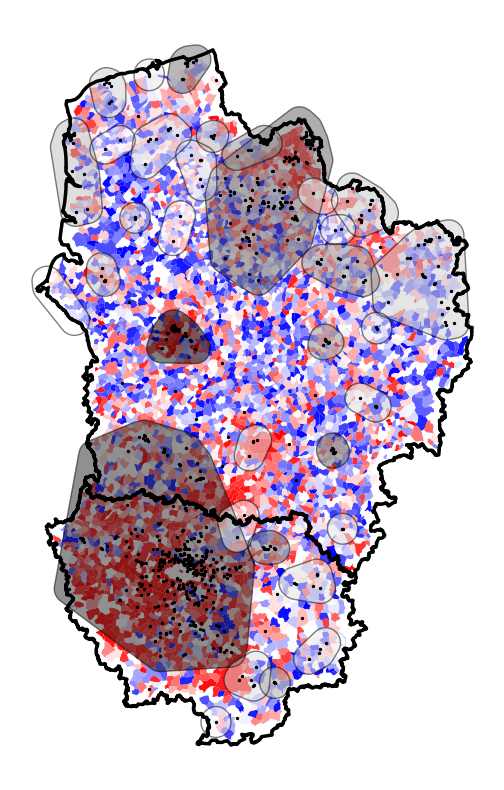

In [420]:
ax = diff.plot(alpha=1,figsize=(12, 10), linewidth=0, column="%Cadres", cmap="bwr")
ihdf.boundary.plot(ax=ax, color="black", linewidth=2.5)
polygons.plot(ax=ax, alpha=.5, cmap="Greys", linewidth=1, column="density_km2")
polygons.boundary.plot(ax=ax, alpha=.5, color='black', linewidth=1)
friches_ihdf.plot(ax=ax, markersize=2, color="black")
ax.axis('off')
plt.show()

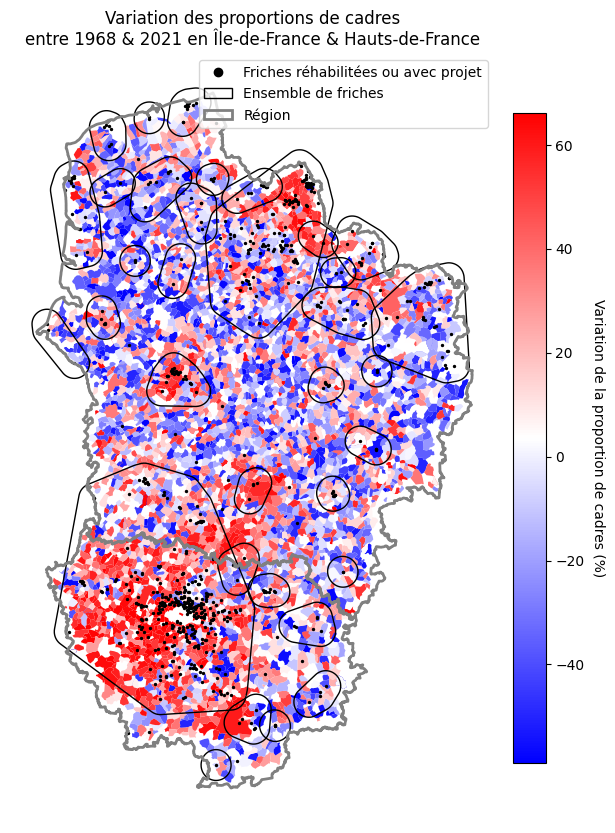

In [421]:
fig, ax = plt.subplots(figsize=(12, 10))

diff.plot(
    ax=ax,
    alpha=1,
    linewidth=0,
    column="%Cadres",
    cmap="bwr",
    legend=False
)

polygons.boundary.plot(ax=ax, color='black', linewidth=1)

friches_ihdf.plot(ax=ax, markersize=2, color="black")

ihdf.boundary.plot(ax=ax, color="grey", linewidth=2)

norm = mpl.colors.Normalize(vmin=diff["%Cadres"].min(), 
                            vmax=diff["%Cadres"].max())

sm = mpl.cm.ScalarMappable(cmap="bwr", norm=norm)
sm._A = []
cbar = plt.colorbar(sm, ax=ax, fraction=0.035, pad=0.02)
cbar.set_label("Variation de la proportion de cadres (%)", rotation=270, labelpad=15)

legend_elements = [
    Line2D([0], [0], marker='o', color='black', linestyle='',
           markersize=6, label="Friches réhabilitées ou avec projet"),
    
    Patch(facecolor='none', edgecolor='black', linewidth=1,
          label="Ensemble de friches"),

    Patch(facecolor='none', edgecolor='grey', linewidth=2,
          label="Région")
]

ax.legend(
    handles=legend_elements,
    loc='best',
    frameon=True
)

ax.set_title("Variation des proportions de cadres\nentre 1968 & 2021 en Île-de-France & Hauts-de-France")
ax.axis('off')

plt.show()

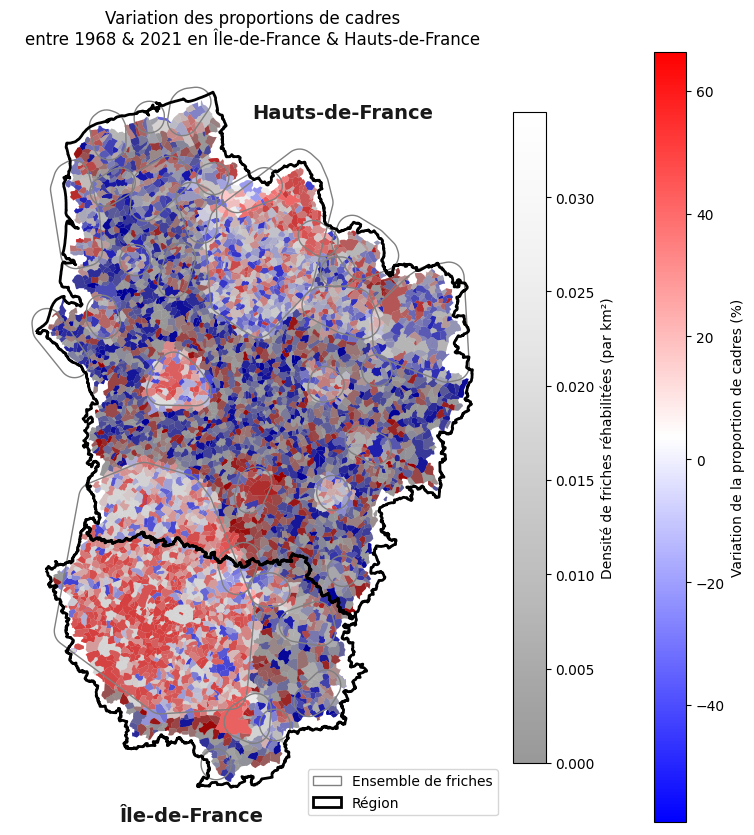

In [422]:
fig, ax = plt.subplots(figsize=(12, 10))

diff.plot(
    ax=ax,
    alpha=1,
    linewidth=0,
    column="%Cadres",
    cmap="bwr",
    legend=False
)

polygons.boundary.plot(ax=ax, color='grey', linewidth=1)

communes.plot(ax=ax, column="density_km2", cmap="Greys_r", alpha=0.4, linewidth=0)

ihdf.boundary.plot(ax=ax, color="black", linewidth=2)

norm2 = mpl.colors.Normalize(
    vmin=communes["density_km2"].min(), 
    vmax=communes["density_km2"].max()
)
sm = mpl.cm.ScalarMappable(cmap="Greys_r", norm=norm2)
sm._A = []
cbar = plt.colorbar(sm, ax=ax, fraction=0.035, pad=0.02, alpha=0.4)
cbar.set_label("Densité de friches réhabilitées (par km²)")

norm = mpl.colors.Normalize(
    vmin=diff["%Cadres"].min(), 
    vmax=diff["%Cadres"].max()
)
sm = mpl.cm.ScalarMappable(cmap="bwr", norm=norm)
sm._A = []
pos = cbar.ax.get_position()
cax2 = fig.add_axes([0.99, pos.y0, pos.width, pos.height])
cbar2 = plt.colorbar(sm, cax=cax2)
cbar2.set_label("Variation de la proportion de cadres (%)")


legend_elements = [
    
    Patch(facecolor='none', edgecolor='grey', linewidth=1,
          label="Ensemble de friches"),

    Patch(facecolor='none', edgecolor='black', linewidth=2,
          label="Région")
]

ax.text(2.4, 48, "Île-de-France",
        fontsize=14, fontweight="bold",
        ha="center", va="center",
        color="black", alpha=0.9)

ax.text(3.4, 51, "Hauts-de-France",
        fontsize=14, fontweight="bold",
        ha="center", va="center",
        color="black", alpha=0.9)

ax.legend(
    handles=legend_elements,
    loc='lower left',
    bbox_to_anchor=(0.6, 0),
    frameon=True
)

ax.set_title("Variation des proportions de cadres\nentre 1968 & 2021 en Île-de-France & Hauts-de-France")
ax.axis('off')

plt.show()

<Axes: xlabel='%Cadres', ylabel='Count'>

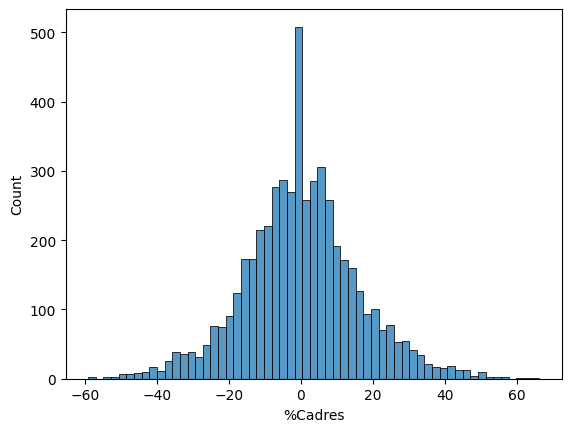

In [423]:
sns.histplot(diff, x="%Cadres")

In [424]:
clean = diff.copy()

clean['%Cadres'] = pd.to_numeric(clean['%Cadres'], errors='coerce')
clean['density_km2'] = pd.to_numeric(clean['density_km2'], errors='coerce')
clean = clean[['%Cadres','density_km2']].dropna()

pearsonr(clean['%Cadres'], clean['density_km2'])

PearsonRResult(statistic=np.float64(0.2700463271965404), pvalue=np.float64(4.508616533727956e-87))

<Axes: xlabel='density_km2', ylabel='%Cadres'>

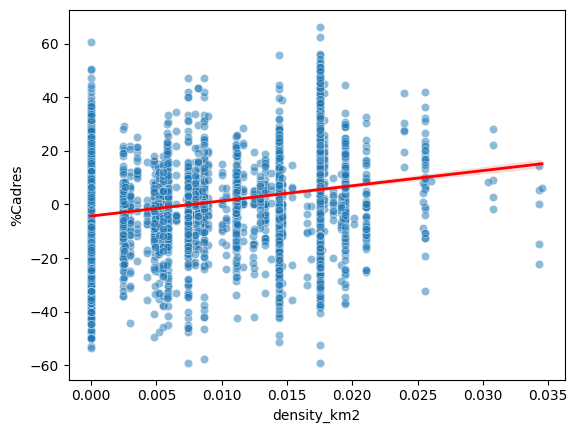

In [425]:
sns.scatterplot(data=clean, x="density_km2", y="%Cadres", alpha=0.5)
sns.regplot(data=clean, x="density_km2", y="%Cadres", color="red", scatter=False, line_kws={"linewidth":2})

In [426]:
ihdf.total_bounds

array([ 1.38065, 48.12054,  4.2557 , 51.089  ])

<Axes: >

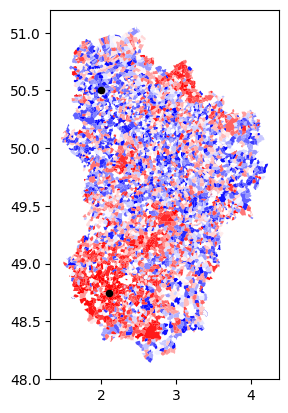

In [427]:
centroids = gpd.GeoDataFrame(geometry=[Point(2.1, 48.75), Point(2.0003, 50.5)], crs="EPSG:4326")
centroids = centroids.to_crs(ihdf.crs)

ax = diff.plot(
    alpha=1,
    linewidth=0,
    column="%Cadres",
    cmap="bwr",
    legend=False
)
centroids.plot(ax=ax, markersize=20, color="black")

<Axes: >

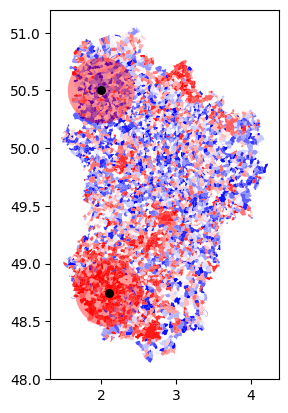

In [428]:
# Reprojection en mètres
centroids_m = centroids.to_crs("EPSG:3857")

# Buffer de 500 mètres
buffers_m = centroids_m.buffer(50000)

# Reprojection vers WGS84 si tu veux les afficher sur une carte en 4326
buffers = buffers_m.to_crs("EPSG:4326")

ax = diff.plot(
    alpha=1,
    linewidth=0,
    column="%Cadres",
    cmap="bwr",
    legend=False
)
buffers.plot(ax=ax, color="red", alpha=0.4)
centroids.plot(ax=ax, color="black", markersize=30)


In [429]:
buffer1 = buffers.iloc[0] 
buffer2 = buffers.iloc[1] 
diff1 = diff[diff.geometry.within(buffer1)] 
diff2 = diff[diff.geometry.within(buffer2)] 
friches_ihdf1 = friches_ihdf[friches_ihdf.geometry.within(buffer1)] 
friches_ihdf2 = friches_ihdf[friches_ihdf.geometry.within(buffer2)] 

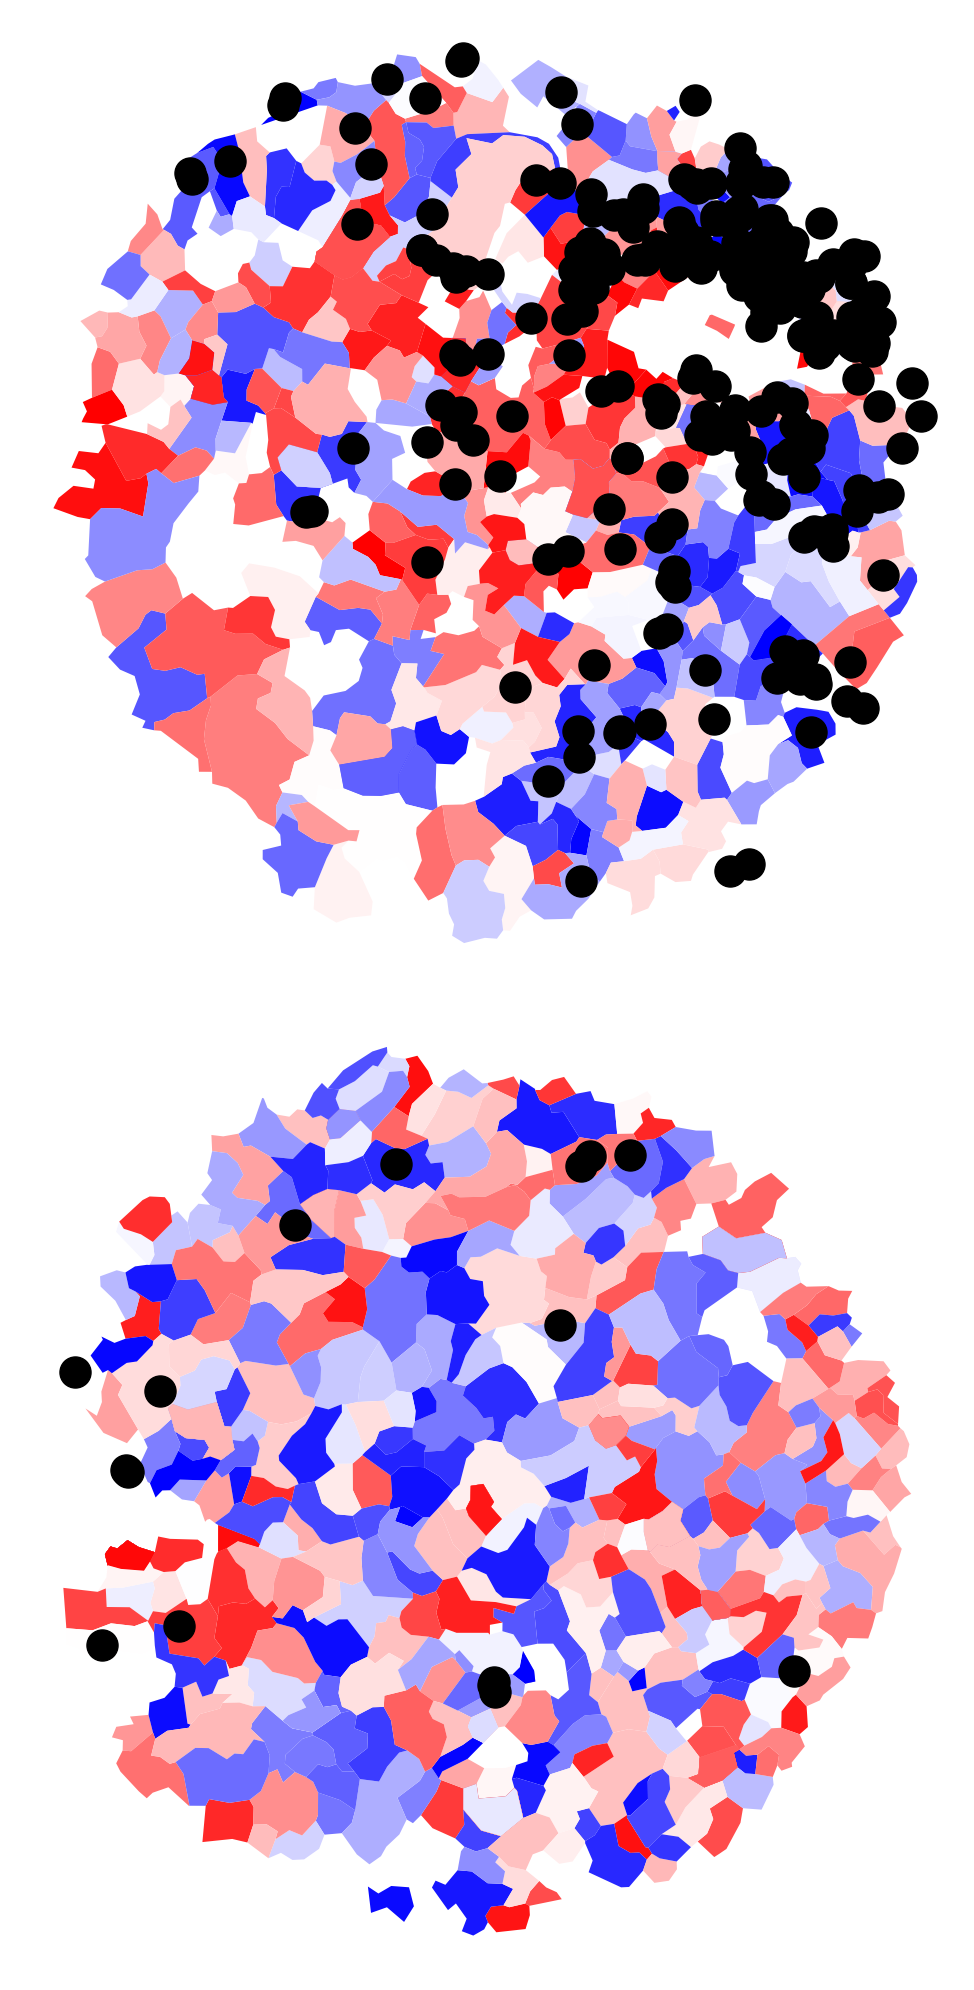

In [441]:
buffer1 = buffers.iloc[0]
buffer2 = buffers.iloc[1]

# Sélections
diff1 = diff[diff.geometry.within(buffer1)]
diff2 = diff[diff.geometry.within(buffer2)]

friches_ihdf1 = friches_ihdf[friches_ihdf.geometry.within(buffer1)]
friches_ihdf2 = friches_ihdf[friches_ihdf.geometry.within(buffer2)]

# --- Figure à 2 lignes et 1 colonne ---
fig, axes = plt.subplots(2, 1, figsize=(12, 20))

# -------------------
# Carte 1 – buffer 1
# -------------------
diff1.plot(
    ax=axes[0],
    alpha=1,
    linewidth=0,
    column="%Cadres",
    cmap="bwr",
    legend=False
)

friches_ihdf1.plot(ax=axes[0], markersize=500, color="black")

axes[0].axis("off")

# -------------------
# Carte 2 – buffer 2
# -------------------
diff2.plot(
    ax=axes[1],
    alpha=1,
    linewidth=0,
    column="%Cadres",
    cmap="bwr",
    legend=False
)

friches_ihdf2.plot(ax=axes[1], markersize=500, color="black")

axes[1].axis("off")

plt.tight_layout()
plt.show()


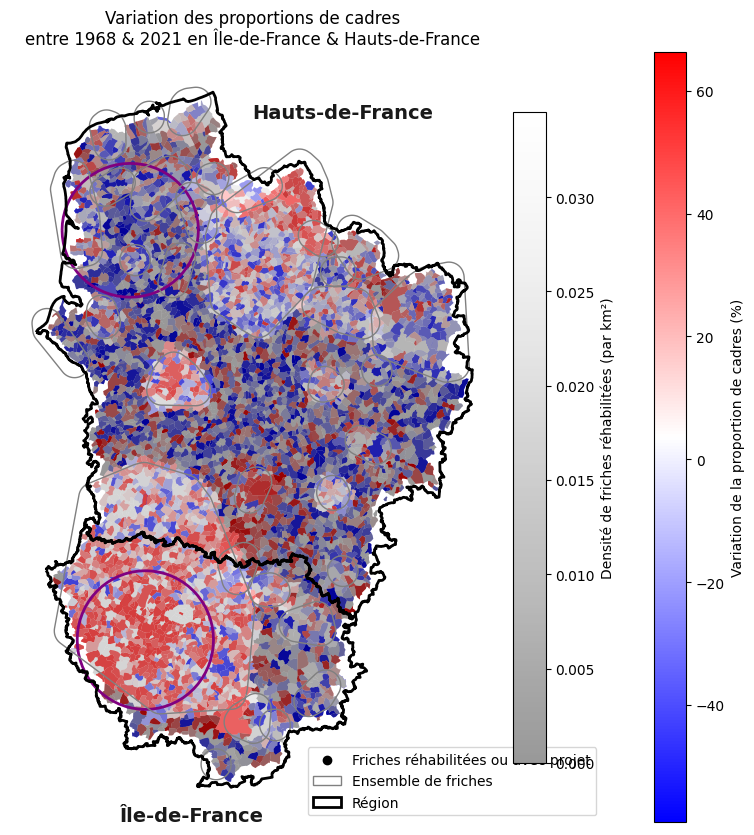

In [431]:
fig, ax = plt.subplots(figsize=(12, 10))

diff.plot(
    ax=ax,
    alpha=1,
    linewidth=0,
    column="%Cadres",
    cmap="bwr",
    legend=False
)

buffers.boundary.plot(ax=ax, linewidth=2, color="purple")

polygons.boundary.plot(ax=ax, color='grey', linewidth=1)

communes.plot(ax=ax, column="density_km2", cmap="Greys_r", alpha=0.4, linewidth=0)

ihdf.boundary.plot(ax=ax, color="black", linewidth=2)

norm2 = mpl.colors.Normalize(
    vmin=communes["density_km2"].min(), 
    vmax=communes["density_km2"].max()
)
sm = mpl.cm.ScalarMappable(cmap="Greys_r", norm=norm2)
sm._A = []
cbar = plt.colorbar(sm, ax=ax, fraction=0.035, pad=0.02, alpha=0.4)
cbar.set_label("Densité de friches réhabilitées (par km²)")

norm = mpl.colors.Normalize(
    vmin=diff["%Cadres"].min(), 
    vmax=diff["%Cadres"].max()
)
sm = mpl.cm.ScalarMappable(cmap="bwr", norm=norm)
sm._A = []
pos = cbar.ax.get_position()
cax2 = fig.add_axes([0.99, pos.y0, pos.width, pos.height])
cbar2 = plt.colorbar(sm, cax=cax2)
cbar2.set_label("Variation de la proportion de cadres (%)")


legend_elements = [
    Line2D([0], [0], marker='o', color='black', linestyle='',
           markersize=6, label="Friches réhabilitées ou avec projet"),
               
    Patch(facecolor='none', edgecolor='grey', linewidth=1,
          label="Ensemble de friches"),

    Patch(facecolor='none', edgecolor='black', linewidth=2,
          label="Région")
]

ax.text(2.4, 48, "Île-de-France",
        fontsize=14, fontweight="bold",
        ha="center", va="center",
        color="black", alpha=0.9)

ax.text(3.4, 51, "Hauts-de-France",
        fontsize=14, fontweight="bold",
        ha="center", va="center",
        color="black", alpha=0.9)

ax.legend(
    handles=legend_elements,
    loc='lower left',
    bbox_to_anchor=(0.6, 0),
    frameon=True
)

ax.set_title("Variation des proportions de cadres\nentre 1968 & 2021 en Île-de-France & Hauts-de-France")
ax.axis('off')

plt.show()

In [432]:
folder = "data"

pattern = re.compile(r"CSP(\d{4})\.csv$")

csv_dict = {}

for filename in os.listdir(folder):
    match = pattern.match(filename)
    if match:
        key = match.group(1)

        filepath = os.path.join(folder, filename)

        df = pd.read_csv(filepath, low_memory=False)

        csv_dict[key] = df

In [433]:
import pandas as pd
import numpy as np

def process_csp(df):
    df.iloc[:, 6:] = df.iloc[:, 6:].apply(
        lambda x: pd.to_numeric(
            x.str.replace('\u202f','', regex=False) if x.dtype == 'object' else x,
            errors='coerce'
        )
    )

    df = df[df["Région en géographie courante"].isin([11, 32])]

    df["Total"] = df.iloc[:, 6:].sum(axis=1)

    df = df[df["Total"] > 0]

    df["Cadres_pct"] = (
        df["Cadres et professions intellectuelles supérieures Actifs ayant un emploi RP2021"]
        / df["Total"] * 100
    )

    df = df[
        ["Libellé de commune",
         "Cadres_pct",
         "Cadres et professions intellectuelles supérieures Actifs ayant un emploi RP2021",
         "Total"]
    ]

    return df


processed = {} 
for key, df in csv_dict.items():
    year = key  
    processed[year] = process_csp(df)


all_df = pd.concat(
    [df.assign(Année=year) for year, df in processed.items()],
    ignore_index=True
)

final_table = all_df.pivot_table(
    index="Libellé de commune",
    columns="Année",
    values="Cadres_pct"
)

final_table.head()

/tmp/ipykernel_5750/1659048543.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Total"] = df.iloc[:, 6:].sum(axis=1)
/tmp/ipykernel_5750/1659048543.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Total"] = df.iloc[:, 6:].sum(axis=1)
/tmp/ipykernel_5750/1659048543.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

Année                      1968      1975      1982       1990       1999  \
Libellé de commune                                                          
Abancourt                   0.0  4.423077   10.6875   5.882353   4.673206   
Abbecourt                   0.0      6.25  7.692308  11.666667  15.384615   
Abbeville               6.60165  7.520477  6.295672    8.41878   7.555089   
Abbeville-Saint-Lucien      0.0  9.090909  3.703704   2.941176   6.779661   
Abbécourt                   0.0       0.0  9.090909        0.0        0.0   

Année                        2010       2015       2021  
Libellé de commune                                       
Abancourt                3.658537        0.0  12.758621  
Abbecourt               13.333333  24.381625  18.412698  
Abbeville                7.523681   9.245173  10.115196  
Abbeville-Saint-Lucien   9.803922  11.210762    8.02139  
Abbécourt                2.116402   2.777778   5.128205

In [434]:
def process_region_totals(df):

    # ------------------------------
    # 1. Convertir les colonnes numériques
    # ------------------------------
    numeric_cols = df.columns[6:]

    for col in numeric_cols:
        if df[col].dtype == object:
            df[col] = df[col].astype(str).str.replace('\u202f','', regex=False)

    df[numeric_cols] = df[numeric_cols].apply(lambda x: pd.to_numeric(x, errors="coerce"))

    # ------------------------------
    # 2. Garder uniquement IDF (11) et HDF (32)
    # ------------------------------
    df = df[df["Région en géographie courante"].isin([11, 32])]

    # ------------------------------
    # 3. Agrégation par région : somme
    # ------------------------------
    df_region = df.groupby("Région en géographie courante", as_index=False).sum()

    # ------------------------------
    # 4. Calcul du total
    # ------------------------------
    df_region["Total"] = df_region[numeric_cols].sum(axis=1)

    # ------------------------------
    # 5. Pourcentage de cadres
    # ------------------------------
    col_cadres = "Cadres et professions intellectuelles supérieures Actifs ayant un emploi RP2021"

    df_region["Cadres_pct"] = df_region[col_cadres] / df_region["Total"] * 100

    return df_region[["Région en géographie courante", "Cadres_pct"]]

processed = {}

for year, df in csv_dict.items():
    out = process_region_totals(df)
    out["Année"] = year
    processed[year] = out


all_years = pd.concat(processed.values(), ignore_index=True)

final_table = all_years.pivot(
    index="Année",
    columns="Région en géographie courante",
    values="Cadres_pct"
)

# Renommer les colonnes pour plus de lisibilité
final_table = final_table.rename(columns={11: "IDF", 32: "HDF"})

final_table.head()


Région en géographie courante        IDF       HDF
Année                                             
1968                           10.920592  4.575257
1975                           13.354744  6.313475
1982                           16.245812  7.091698
1990                           20.323512  8.659898
1999                           21.335133  9.087125

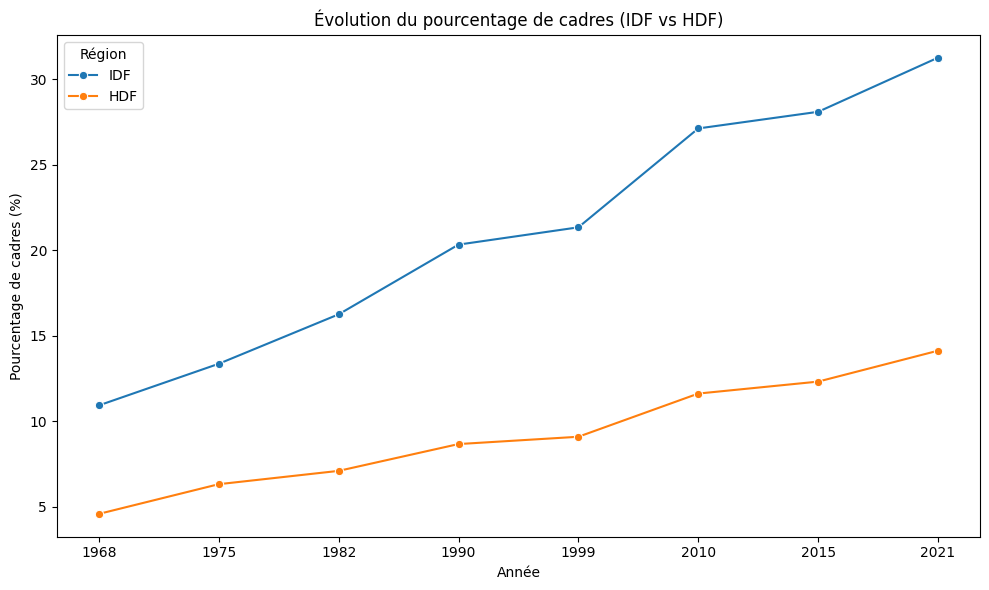

In [435]:
df_plot = final_table.reset_index().melt(id_vars="Année", var_name="Région", value_name="Cadres_pct")

plt.figure(figsize=(10,6))
sns.lineplot(data=df_plot, x="Année", y="Cadres_pct", hue="Région", marker="o")
plt.title("Évolution du pourcentage de cadres (IDF vs HDF)")
plt.ylabel("Pourcentage de cadres (%)")
plt.xlabel("Année")
plt.tight_layout()

plt.show()

In [436]:
friches_dates_idf = pd.read_csv("data/friches_idf.csv")
friches_dates_idf.head()

friches_dates_hdf = pd.read_csv("data/friches_hdf.csv")

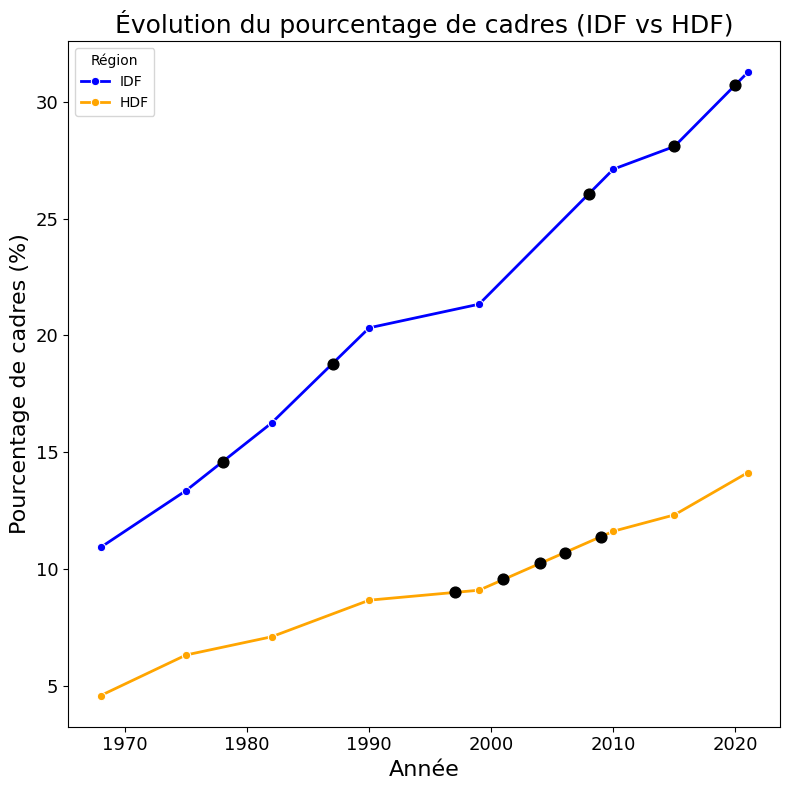

In [439]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Couleurs personnalisées
dark_blue = "#003f5c"
dark_orange = "#bc6c25"

# =============================
# 1. Final_table propre
# =============================
final_table.index = final_table.index.astype(int)
final_table = final_table.sort_index()

# =============================
# 2. Préparation du dataframe pour seaborn
# =============================
df_plot = final_table.reset_index().melt(
    id_vars="Année",
    var_name="Région",
    value_name="Cadres_pct"
)
df_plot["Année"] = df_plot["Année"].astype(int)

# =============================
# 3. Line plot
# =============================
plt.figure(figsize=(8, 8))

sns.lineplot(
    data=df_plot,
    x="Année",
    y="Cadres_pct",
    hue="Région",
    marker="o",
    linewidth=2,
    palette={"IDF": "blue", "HDF": "orange"}
)

# =============================
# 4. Titres plus grands
# =============================

plt.title(
    "Évolution du pourcentage de cadres (IDF vs HDF)",
    fontsize=18               # Titre plus grand
)

plt.xlabel("Année", fontsize=16)          # Axe X plus grand
plt.ylabel("Pourcentage de cadres (%)", fontsize=16)  # Axe Y plus grand

plt.xticks(fontsize=13)   # Taille des ticks
plt.yticks(fontsize=13)

# =============================
# 5. Fonction d’interpolation
# =============================
def interpolate(final_table, year, region):
    x = final_table.index.astype(float)
    y = final_table[region].astype(float).values
    return np.interp(year, x, y)

offset = 1.0   # décalage vertical du texte


# =============================
# 6. Labels + points pour IDF
# =============================
friches_dates_idf["Ouverture"] = friches_dates_idf["Ouverture"].astype(float)

for _, row in friches_dates_idf.iterrows():
    year = row["Ouverture"]
    name = row["name"]
    y_value = interpolate(final_table, year, "IDF")

    plt.scatter(year, y_value, color="black", s=60, zorder=6)

# =============================
# 7. Labels + points pour HDF
# =============================
friches_dates_hdf["Ouverture"] = friches_dates_hdf["Ouverture"].astype(float)

for _, row in friches_dates_hdf.iterrows():
    year = row["Ouverture"]
    name = row["name"]
    y_value = interpolate(final_table, year, "HDF")

    plt.scatter(year, y_value, color="black", s=60, zorder=6)

plt.tight_layout()
plt.show()
